In [ ]:
"""
🎯 퍼포먼스 마케팅 자동화 분석 스크립트
- 광고 데이터 전처리 → KPI 계산 → 성과 분석 → 시각화 → 리포트 자동 생성
- 파일만 교체하면 계속 재사용 가능한 구조

📌 사용법:
1. 광고 데이터 CSV/Excel 파일 준비
2. 아래 [설정 영역]의 파일명과 컬럼명만 수정
3. python performance_marketing_analyzer.py 실행
"""

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (matplotlib 한글 깨짐 방지)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("🚀 퍼포먼스 마케팅 자동화 분석 시작")
print("=" * 60)

🚀 퍼포먼스 마케팅 자동화 분석 시작


In [ ]:
# ============================================================
# 📌 [설정 영역] - 여기만 수정하면 됩니다!
# ============================================================

In [4]:
#1️⃣ 데이터 파일 경로 (CSV 또는 Excel)
INPUT_FILE = 'ad_data.csv'  # ❤️ 실제 파일명으로 변경하세요


In [5]:
# 2️⃣ 파일 형식 선택
FILE_TYPE = 'csv'  # ❤️ 'csv' 또는 'excel' 중 선택하세요

In [7]:
df = pd.read_csv("ad_data.csv")
print(df.shape)
df.head()

(27, 8)


,date,campaign,media,impressions,clicks,cost,conversions,revenue
0,2024-01-01,Brand_Campaign_A,Google,150000,3500,350000,85,1700000
1,2024-01-01,Performance_Campaign_B,Facebook,200000,5200,420000,120,2400000
2,2024-01-01,Retargeting_Campaign_C,Instagram,80000,2100,180000,55,1100000
3,2024-01-02,Brand_Campaign_A,Google,155000,3600,360000,90,1800000
4,2024-01-02,Performance_Campaign_B,Facebook,210000,5500,440000,130,2600000


In [26]:
# 3️⃣ 컬럼명 매핑 (실제 데이터의 컬럼명에 맞게 수정)
COLUMN_MAPPING = {
    'date': 'date',           # ❤️ 날짜 컬럼명 (예: 'date', '날짜', 'Date')
    'campaign': 'campaign',   # ❤️ 캠페인명 컬럼 (예: 'campaign', '캠페인명', 'Campaign_Name')
    'media': 'media',         # ❤️ 매체 컬럼 (예: 'media', '매체', 'Media_Source')
    'impressions': 'impressions',  # ❤️ 노출수 컬럼명
    'clicks': 'clicks',       # ❤️ 클릭수 컬럼명
    'cost': 'cost',           # ❤️ 광고비 컬럼 (예: 'cost', '광고비', 'Spend')
    'conversions': 'conversions',  # ❤️ 전환수 컬럼 (예: 'conversions', '전환', 'Purchases')
    'revenue': 'revenue'      # ❤️ 매출 컬럼 (예: 'revenue', '매출', 'Sales')
    }

In [28]:
# 5️⃣ 최소 클릭수 기준 (통계적 유의성 확보)
MIN_CLICKS = 100  # ❤️ 캠페인 분석 시 최소 클릭수 기준 (낮으면 더 많은 캠페인 포함, 높으면 신뢰도 향상)

In [29]:
# 6️⃣ 출력 파일명
OUTPUT_EXCEL = 'marketing_report.xlsx'  # ❤️ 생성될 엑셀 리포트 파일명
OUTPUT_CHART = 'performance_chart.png'  # ❤️ 생성될 시각화 차트 파일명


# 1️⃣ 광고 데이터 불러오기 + 기본 전처리

In [10]:
print("\n📂 1단계: 데이터 불러오기 및 전처리")
print("-" * 60)


📂 1단계: 데이터 불러오기 및 전처리
------------------------------------------------------------


In [25]:
try:
    # 파일 형식에 따라 로드
    if FILE_TYPE == 'csv':
        df = pd.read_csv(INPUT_FILE)
    elif FILE_TYPE == 'excel':
        df = pd.read_excel(INPUT_FILE)
    else:
        raise ValueError("FILE_TYPE은 'csv' 또는 'excel'만 가능합니다.")
    
    print(f"✅ 파일 로드 완료: {INPUT_FILE}")
    print(f"   - 총 {len(df):,}개 행, {len(df.columns)}개 컬럼")
    
    # 컬럼명 통일 (실제 데이터 컬럼명 → 표준 컬럼명)
    df = df.rename(columns={v: k for k, v in COLUMN_MAPPING.items()})
    
    # 날짜 형식 변환
    df['date'] = pd.to_datetime(df['date'])
    
    # 결측치 처리 (0으로 채우기)
    numeric_cols = ['impressions', 'clicks', 'cost', 'conversions', 'revenue']
    df[numeric_cols] = df[numeric_cols].fillna(0)
    
    # 이상치 제거 (음수 값 제거)
    df = df[(df[numeric_cols] >= 0).all(axis=1)]
    
    print("✅ 전처리 완료")
    print(f"   - 날짜 범위: {df['date'].min()} ~ {df['date'].max()}")
    print(f"   - 캠페인 수: {df['campaign'].nunique()}개")
    print(f"   - 매체 수: {df['media'].nunique()}개")
    
except FileNotFoundError:
    print(f"❌ 오류: '{INPUT_FILE}' 파일을 찾을 수 없습니다.")
    print("   👉 파일명과 경로를 확인하세요.")
    exit()
except Exception as e:
    print(f"❌ 오류 발생: {e}")
    exit()

# 2️⃣ 퍼포먼스 핵심 KPI 계산 (실무 필수)

In [14]:
print("\n📊 2단계: 핵심 KPI 계산")
print("-" * 60)

# CTR (Click Through Rate) = 클릭수 / 노출수 * 100
df['CTR'] = np.where(df['impressions'] > 0, 
                     (df['clicks'] / df['impressions'] * 100), 0)

# CPC (Cost Per Click) = 광고비 / 클릭수
df['CPC'] = np.where(df['clicks'] > 0, 
                     df['cost'] / df['clicks'], 0)

# CVR (Conversion Rate) = 전환수 / 클릭수 * 100
df['CVR'] = np.where(df['clicks'] > 0, 
                     (df['conversions'] / df['clicks'] * 100), 0)

# CPA (Cost Per Acquisition) = 광고비 / 전환수
df['CPA'] = np.where(df['conversions'] > 0, 
                     df['cost'] / df['conversions'], 0)

# ROAS (Return On Ad Spend) = 매출 / 광고비 * 100
df['ROAS'] = np.where(df['cost'] > 0, 
                      (df['revenue'] / df['cost'] * 100), 0)

# CPI (Cost Per Impression, CPM) = 광고비 / 노출수 * 1000
df['CPM'] = np.where(df['impressions'] > 0, 
                     (df['cost'] / df['impressions'] * 1000), 0)

print("✅ KPI 계산 완료")
print(f"   - CTR 평균: {df['CTR'].mean():.2f}%")
print(f"   - CPC 평균: {df['CPC'].mean():,.0f}원")
print(f"   - CVR 평균: {df['CVR'].mean():.2f}%")
print(f"   - CPA 평균: {df['CPA'].mean():,.0f}원")
print(f"   - ROAS 평균: {df['ROAS'].mean():.0f}%")
print(f"   - CPM 평균: {df['CPM'].mean():,.0f}원")


# 3️⃣ 매체별 성과 분석 (groupby)
# ============================================================
print("\n📈 3단계: 매체별 성과 분석")
print("-" * 60)

media_performance = df.groupby('media').agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'cost': 'sum',
    'conversions': 'sum',
    'revenue': 'sum',
    'CTR': 'mean',
    'CPC': 'mean',
    'CVR': 'mean',
    'CPA': 'mean',
    'ROAS': 'mean'
}).round(2)

# 매체별 점유율 계산
media_performance['cost_share'] = (media_performance['cost'] / media_performance['cost'].sum() * 100).round(1)
media_performance['conversion_share'] = (media_performance['conversions'] / media_performance['conversions'].sum() * 100).round(1)

# ROAS 기준 내림차순 정렬
media_performance = media_performance.sort_values('ROAS', ascending=False)

print("✅ 매체별 분석 완료")
print("\n[매체별 ROAS Top 3]")
print(media_performance[['cost', 'conversions', 'ROAS']].head(3))



📊 2단계: 핵심 KPI 계산
------------------------------------------------------------
✅ KPI 계산 완료
   - CTR 평균: 2.37%
   - CPC 평균: 95원
   - CVR 평균: 2.44%
   - CPA 평균: 3,958원
   - ROAS 평균: 533%
   - CPM 평균: 2,188원

📈 3단계: 매체별 성과 분석
------------------------------------------------------------
✅ 매체별 분석 완료

[매체별 ROAS Top 3]
              cost  conversions    ROAS
media                                  
Instagram  1313000          407  619.06
Facebook   3035000          893  587.99
Naver      1170000          315  538.26


# 4️⃣ 전환율 높은 캠페인 찾기

In [30]:
print("\n🎯 4단계: 고성과 캠페인 분석")
print("-" * 60)

campaign_performance = df.groupby('campaign').agg({
    'clicks': 'sum',
    'cost': 'sum',
    'conversions': 'sum',
    'revenue': 'sum',
    'CVR': 'mean',
    'CPA': 'mean',
    'ROAS': 'mean'
}).round(2)

# 최소 클릭수 필터 (통계적 유의성 확보) - 상단 MIN_CLICKS 변수 사용
campaign_performance = campaign_performance[campaign_performance['clicks'] >= MIN_CLICKS]  # ❤️ MIN_CLICKS 값 조정은 상단 설정 영역에서

# CVR 상위 캠페인
top_cvr_campaigns = campaign_performance.nlargest(5, 'CVR')  # ❤️ 5를 다른 숫자로 변경하면 더 많거나 적은 캠페인 출력

# ROAS 상위 캠페인
top_roas_campaigns = campaign_performance.nlargest(5, 'ROAS')  # ❤️ 5를 다른 숫자로 변경하면 더 많거나 적은 캠페인 출력

print("✅ 캠페인 분석 완료")
print(f"\n[CVR Top 5 캠페인]")
print(top_cvr_campaigns[['CVR', 'conversions', 'CPA']])
print(f"\n[ROAS Top 5 캠페인]")
print(top_roas_campaigns[['ROAS', 'revenue', 'cost']])


🎯 4단계: 고성과 캠페인 분석
------------------------------------------------------------
✅ 캠페인 분석 완료

[CVR Top 5 캠페인]
                         CVR  conversions      CPA
campaign                                          
Retargeting_Campaign_C  2.68          407  3235.63
Brand_Campaign_A        2.47          617  4054.12
Performance_Campaign_D  2.44          315  3716.88
Performance_Campaign_B  2.36          893  3402.91
Video_Campaign_E        1.99          233  6952.14

[ROAS Top 5 캠페인]
                          ROAS   revenue     cost
campaign                                         
Retargeting_Campaign_C  619.06   8140000  1313000
Performance_Campaign_B  587.99  17860000  3035000
Performance_Campaign_D  538.26   6300000  1170000
Brand_Campaign_A        493.68  12340000  2498000
Video_Campaign_E        287.69   4660000  1620000


# 5️⃣ A/B 테스트 분석 (통계검정)

In [31]:
print("\n🧪 5단계: A/B 테스트 통계 분석")
print("-" * 60)

# 상위 2개 그룹만 비교 (A/B 테스트)
top_groups = df.groupby(AB_TEST_COLUMN)['conversions'].sum().nlargest(2).index.tolist()

if len(top_groups) >= 2:
    group_a = df[df[AB_TEST_COLUMN] == top_groups[0]]['CVR'].dropna()
    group_b = df[df[AB_TEST_COLUMN] == top_groups[1]]['CVR'].dropna()
    
    # t-검정 (독립표본 t-test)
    t_stat, p_value = stats.ttest_ind(group_a, group_b)
    
    print(f"✅ A/B 테스트 실행")
    print(f"   - Group A ({top_groups[0]}): CVR 평균 {group_a.mean():.2f}%")
    print(f"   - Group B ({top_groups[1]}): CVR 평균 {group_b.mean():.2f}%")
    print(f"   - t-통계량: {t_stat:.3f}")
    print(f"   - p-value: {p_value:.4f}")
    
    # ❤️ 유의수준 변경 시: 0.05를 0.01 또는 0.1로 변경 가능 (0.05 = 95% 신뢰수준)
    if p_value < 0.05:
        print("   ✅ 통계적으로 유의미한 차이 있음 (p < 0.05)")
    else:
        print("   ⚠️  통계적으로 유의미한 차이 없음 (p >= 0.05)")
else:
    print("⚠️  A/B 테스트를 위한 그룹이 부족합니다.")


🧪 5단계: A/B 테스트 통계 분석
------------------------------------------------------------
✅ A/B 테스트 실행
   - Group A (Performance_Campaign_B): CVR 평균 2.36%
   - Group B (Brand_Campaign_A): CVR 평균 2.47%
   - t-통계량: -3.408
   - p-value: 0.0052
   ✅ 통계적으로 유의미한 차이 있음 (p < 0.05)


# 6️⃣ 광고 성과 시각화


📊 6단계: 성과 시각화
------------------------------------------------------------
✅ 차트 저장 완료: performance_chart.png


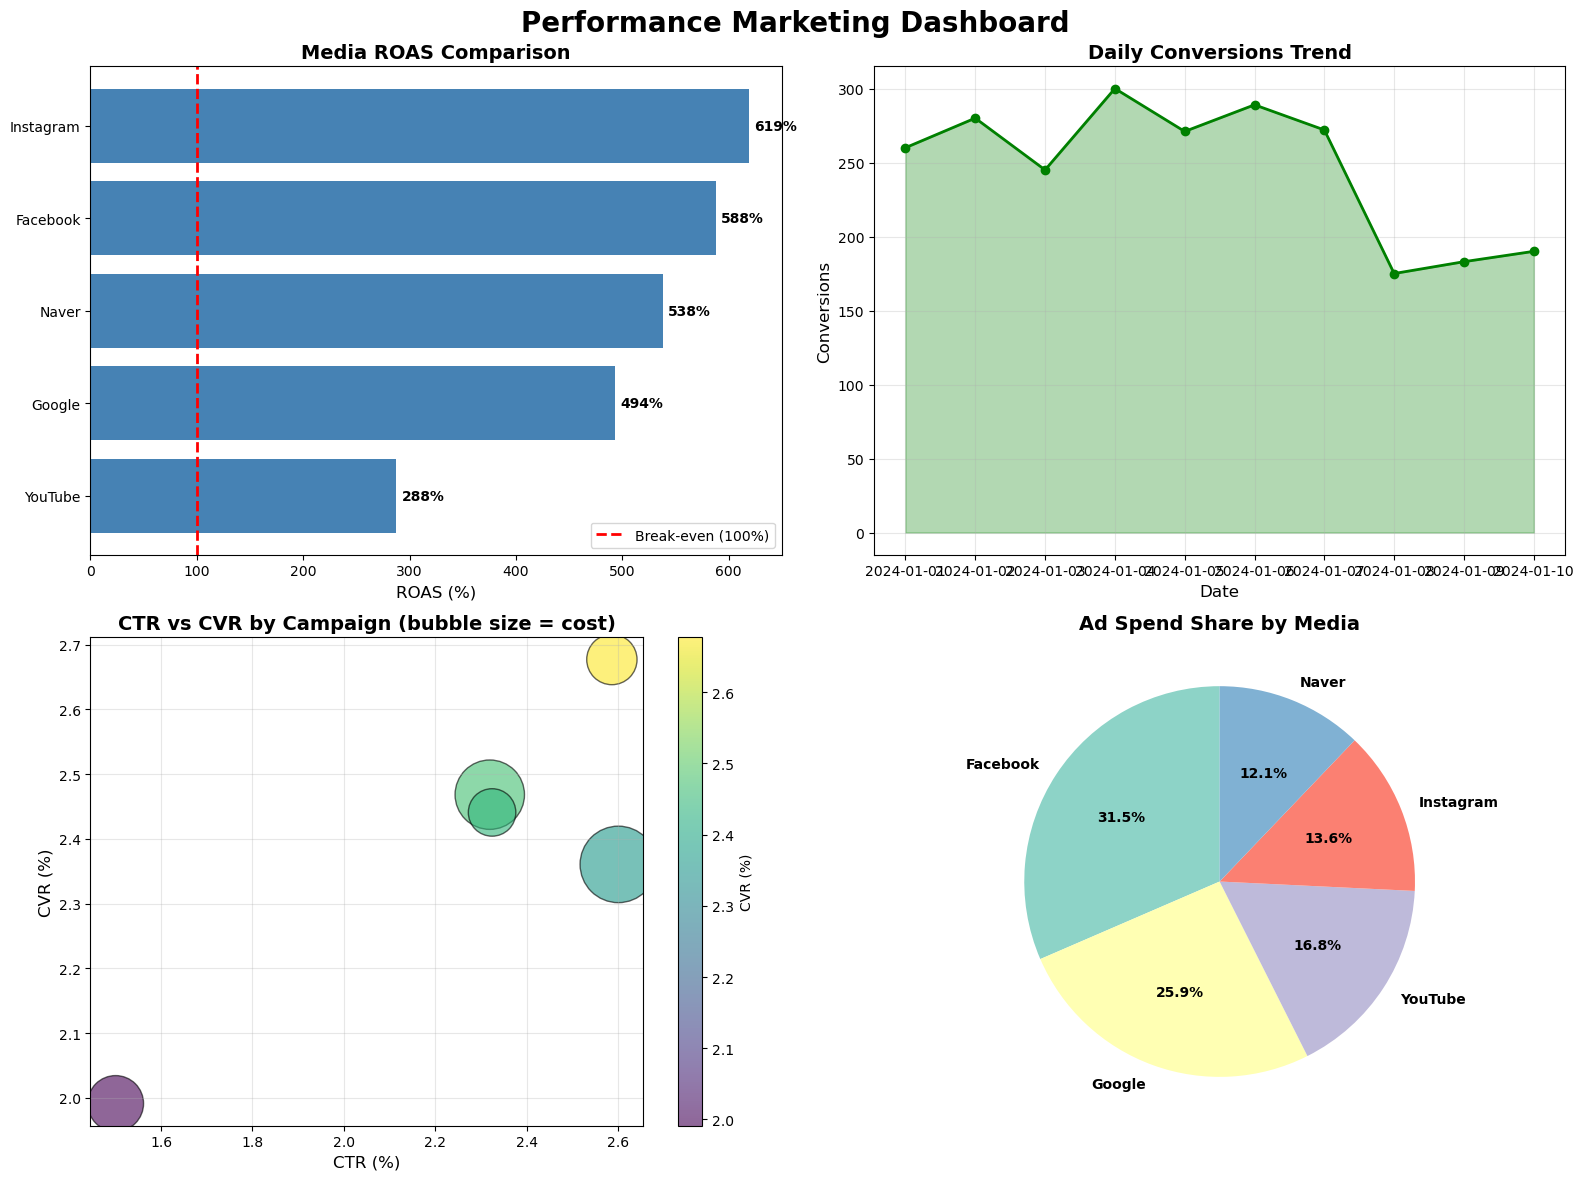

In [33]:
print("\n📊 6단계: 성과 시각화")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Marketing Dashboard', fontsize=20, fontweight='bold')

# 차트 1: 매체별 ROAS 비교
ax1 = axes[0, 0]
media_performance_sorted = media_performance.sort_values('ROAS', ascending=True)
ax1.barh(media_performance_sorted.index, media_performance_sorted['ROAS'], color='steelblue')
ax1.set_xlabel('ROAS (%)', fontsize=12)
ax1.set_title('Media ROAS Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=100, color='red', linestyle='--', linewidth=2, label='Break-even (100%)')  # ❤️ Break-even 기준 변경 시 100을 다른 값으로
ax1.legend()
for i, v in enumerate(media_performance_sorted['ROAS']):
    ax1.text(v + 5, i, f'{v:.0f}%', va='center', fontweight='bold')

# 차트 2: 일별 전환수 추이
ax2 = axes[0, 1]
daily_conversions = df.groupby('date')['conversions'].sum()
ax2.plot(daily_conversions.index, daily_conversions.values, marker='o', linewidth=2, color='green')
ax2.fill_between(daily_conversions.index, daily_conversions.values, alpha=0.3, color='green')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Conversions', fontsize=12)
ax2.set_title('Daily Conversions Trend', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 차트 3: CTR vs CVR 산점도 (캠페인별)
ax3 = axes[1, 0]
campaign_scatter = df.groupby('campaign').agg({'CTR': 'mean', 'CVR': 'mean', 'cost': 'sum'})
scatter = ax3.scatter(campaign_scatter['CTR'], campaign_scatter['CVR'], 
                     s=campaign_scatter['cost']/1000, alpha=0.6, c=campaign_scatter['CVR'],  # ❤️ 버블 크기 조정: cost/1000을 cost/500 또는 cost/2000으로 변경
                     cmap='viridis', edgecolors='black', linewidth=1)
ax3.set_xlabel('CTR (%)', fontsize=12)
ax3.set_ylabel('CVR (%)', fontsize=12)
ax3.set_title('CTR vs CVR by Campaign (bubble size = cost)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='CVR (%)')

# 차트 4: 매체별 광고비 점유율 (파이 차트)
ax4 = axes[1, 1]
media_cost = df.groupby('media')['cost'].sum().sort_values(ascending=False)
colors = plt.cm.Set3(range(len(media_cost)))
wedges, texts, autotexts = ax4.pie(media_cost.values, labels=media_cost.index, autopct='%1.1f%%',
                                     colors=colors, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax4.set_title('Ad Spend Share by Media', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_CHART, dpi=300, bbox_inches='tight')  # ❤️ dpi 값을 150이나 600으로 변경하면 해상도 조정 가능
print(f"✅ 차트 저장 완료: {OUTPUT_CHART}")

In [ ]:
# 7️⃣ ROAS 예측 (간단한 머신러닝)

In [34]:
print("\n🤖 7단계: ROAS 예측 모델 (머신러닝)")
print("-" * 60)

# 특성 선택 (독립변수) - ❤️ 예측 변수 추가/제거 가능
features = ['impressions', 'clicks', 'cost', 'CTR', 'CPC', 'CVR']  # ❤️ 다른 컬럼 추가 가능 (예: 'CPM', 'CPA')
X = df[features].fillna(0)
y = df['ROAS'].fillna(0)

# 학습/테스트 데이터 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # ❤️ test_size=0.2를 0.3으로 변경하면 70:30 분리

# 선형회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ 예측 모델 학습 완료")
print(f"   - R² Score: {r2:.3f} (1에 가까울수록 정확)")
print(f"   - RMSE: {np.sqrt(mse):.2f}")

# 특성 중요도 (계수 크기)
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False)

print("\n[ROAS 영향 요인 Top 3]")
print(feature_importance.head(3).to_string(index=False))  # ❤️ head(3)을 head(5)로 변경하면 Top 5 출력


🤖 7단계: ROAS 예측 모델 (머신러닝)
------------------------------------------------------------
✅ 예측 모델 학습 완료
   - R² Score: 0.999 (1에 가까울수록 정확)
   - RMSE: 1.90

[ROAS 영향 요인 Top 3]
Feature  Coefficient
    CVR   227.577860
    CTR   186.119412
    CPC     1.870183


In [ ]:
# 8️⃣ 엑셀 자동 리포트 저장

In [37]:
print("\n💾 8단계: 자동 리포트 생성")
print("-" * 60)

with pd.ExcelWriter(OUTPUT_EXCEL, engine='openpyxl') as writer:
    # 시트 1: 원본 데이터 (KPI 포함)
    df.to_excel(writer, sheet_name='Raw_Data', index=False)  # ❤️ sheet_name 변경 가능 (예: '원본데이터')
    
    # 시트 2: 매체별 성과
    media_performance.to_excel(writer, sheet_name='Media_Performance')  # ❤️ sheet_name 변경 가능
    
    # 시트 3: 캠페인별 성과
    campaign_performance.to_excel(writer, sheet_name='Campaign_Performance')  # ❤️ sheet_name 변경 가능
    
    # 시트 4: 일별 집계
    daily_summary = df.groupby('date').agg({
        'impressions': 'sum',
        'clicks': 'sum',
        'cost': 'sum',
        'conversions': 'sum',
        'revenue': 'sum',
        'CTR': 'mean',
        'CVR': 'mean',
        'ROAS': 'mean'
    }).round(2)
    daily_summary.to_excel(writer, sheet_name='Daily_Summary')  # ❤️ sheet_name 변경 가능
    
    # 시트 5: 전체 요약 통계
    summary_stats = pd.DataFrame({
        'Metric': ['Total Impressions', 'Total Clicks', 'Total Cost', 'Total Conversions', 
                   'Total Revenue', 'Avg CTR', 'Avg CVR', 'Avg CPA', 'Avg ROAS'],
        'Value': [
            f"{df['impressions'].sum():,.0f}",
            f"{df['clicks'].sum():,.0f}",
            f"{df['cost'].sum():,.0f}",
            f"{df['conversions'].sum():,.0f}",
            f"{df['revenue'].sum():,.0f}",
            f"{df['CTR'].mean():.2f}%",
            f"{df['CVR'].mean():.2f}%",
            f"{df['CPA'].mean():,.0f}",
            f"{df['ROAS'].mean():.0f}%"
        ]
    })
    summary_stats.to_excel(writer, sheet_name='Summary', index=False)  # ❤️ sheet_name 변경 가능

print(f"✅ 엑셀 리포트 저장 완료: {OUTPUT_EXCEL}")
print("\n[생성된 시트]")
print("   1. Raw_Data - 전체 데이터 + KPI")
print("   2. Media_Performance - 매체별 분석")
print("   3. Campaign_Performance - 캠페인별 분석")
print("   4. Daily_Summary - 일별 집계")
print("   5. Summary - 전체 요약 통계")

# ============================================================
# 🎉 분석 완료
# ============================================================
print("\n" + "=" * 60)
print("✅ 모든 분석 완료!")
print("=" * 60)
print(f"📁 생성된 파일:")
print(f"   - {OUTPUT_EXCEL} (상세 리포트)")
print(f"   - {OUTPUT_CHART} (시각화 대시보드)")
print("\n💡 다음 분석을 위해서는:")
print(f"   1. 새로운 데이터 파일 준비")
print(f"   2. 스크립트 상단 [설정 영역]의 파일명만 수정")
print(f"   3. 다시 실행!")
print("=" * 60)


💾 8단계: 자동 리포트 생성
------------------------------------------------------------
✅ 엑셀 리포트 저장 완료: marketing_report.xlsx

[생성된 시트]
   1. Raw_Data - 전체 데이터 + KPI
   2. Media_Performance - 매체별 분석
   3. Campaign_Performance - 캠페인별 분석
   4. Daily_Summary - 일별 집계
   5. Summary - 전체 요약 통계

✅ 모든 분석 완료!
📁 생성된 파일:
   - marketing_report.xlsx (상세 리포트)
   - performance_chart.png (시각화 대시보드)

💡 다음 분석을 위해서는:
   1. 새로운 데이터 파일 준비
   2. 스크립트 상단 [설정 영역]의 파일명만 수정
   3. 다시 실행!
